 **Project: Using NLP for Requirements Engineering for Data Management Software**
 
Source data: Stackoverflow question and answers concerning Azure Data Factory 
    
    Tags: azure-data-factory, adf 
    
    Title keywords: azure data factory, adf
    
Link to data source: https://data.stackexchange.com/stackoverflow/query/new

Link to generated schema: https://dbdiagram.io/d/6448f5b26b3194705139098b

Link to GitHub Repo: https://github.com/tanwolf/NLP_Requirements-Engineering

**Purposes of this notebook:** 
- Create final sub-sets of the original data and analyze topics
- Apply final Latent Dirichlet Allocation: A comparison of different settings found that LDA works best with 3 topics, no bigrams or trigrams and no modification to hyperparameters and coherence score
- Apply final Vader Sentiment Analysis
- Apply finla spaCy extractions 
- Feed all results into GPT4 for analysis and interpretation

**SQL Query**

SELECT

    q.Id AS QuestionId,
    
    q.Title AS QuestionTitle,
    
    q.Body AS QuestionBody,
    
    q.Tags AS QuestionTags,
    
    q.CreationDate AS Date,
    
    q.ViewCount AS ViewCount,
    
    q.Score AS Score,
    
    q.AnswerCount AS NumberOfAnswers,
    
    a.Id AS AnswerId,
    
    a.Body AS AnswerBody

FROM 

    Posts q

INNER JOIN 

    Posts a ON a.ParentId = q.Id

WHERE

    q.PostTypeId = 1
    
    AND (
    
        q.Tags LIKE '%<azure-data-factory>%'
        
        OR q.Tags LIKE '%<adf>%'
        
        OR q.Title Like '%<azure data factory>%'
        
        OR q.Title Like '%<adf>%'
        
    )
    
    AND q.CreationDate >= '2018-01-01'
    
    AND q.CreationDate <= '2023-05-03'
    
ORDER BY

    q.CreationDate DESC 

In [ ]:
import pandas as pd
# Load the datasets into pandas DataFrames
df = pd.read_csv('adf_query_lemmatized.csv')

In [2]:
len(df)

8547

In [3]:
import datetime
# Convert the 'Date' column to a datetime object to allow for better manipulation:
df['Date'] = pd.to_datetime(df['Date'])

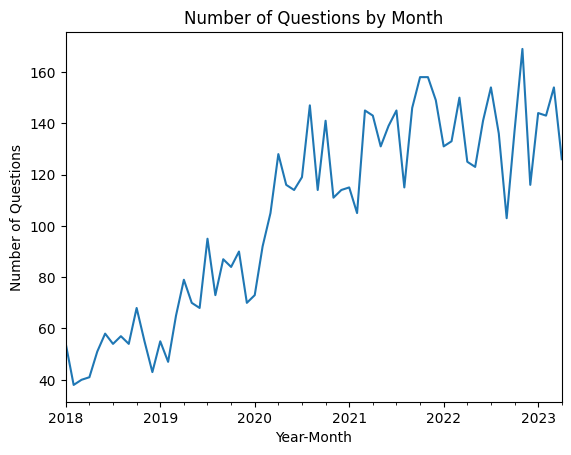

In [4]:
import matplotlib.pyplot as plt
# Analyze the distribution of questions over time:

df['YearMonth'] = df['Date'].dt.to_period('M')

question_count_by_month = df.groupby('YearMonth')['QuestionId'].nunique()
question_count_by_month.plot()
plt.xlabel('Year-Month')
plt.ylabel('Number of Questions')
plt.title('Number of Questions by Month')
plt.show()

In [5]:
# Create a sub-set of data which excludes rows where the creation date is before February 2020. 
# The graph above shows a drastic increase of questions regarding Azure Data Factory around the 
# beginning of the corona virus pandemic in February 2020.

# Use most relevant keywords as filters. Keywords were identified in previous notebooks. 

# Create new column CreationDate to allow filtering
df['CreationDate'] = pd.to_datetime(df['Date'])
start_date = pd.to_datetime('2020-02-01')

# Filter by relevant keywords identified in previous queries
title_keywords = ['mapping', 'data flow', 'dataflow', 'flow', 'pipeline']
body_keywords = ['dataflow', 'data flow', 'flow', 'pipeline', 'following', 'mapping']
tags_keywords = ['pipeline', 'dataflow']

# Create new data frame with date and keyword filters
create_new_df = df[((df['QuestionTitle'].str.contains('|'.join(title_keywords), case=False)) |
                 (df['QuestionBody'].str.contains('|'.join(body_keywords), case=False)) |
                 (df['QuestionTags'].str.contains('|'.join(tags_keywords), case=False))) &
                 (df['CreationDate'] >= start_date)]

In [6]:
len(create_new_df)

4035

In [7]:
df2 = create_new_df.copy()

**Initial Data Exploration**

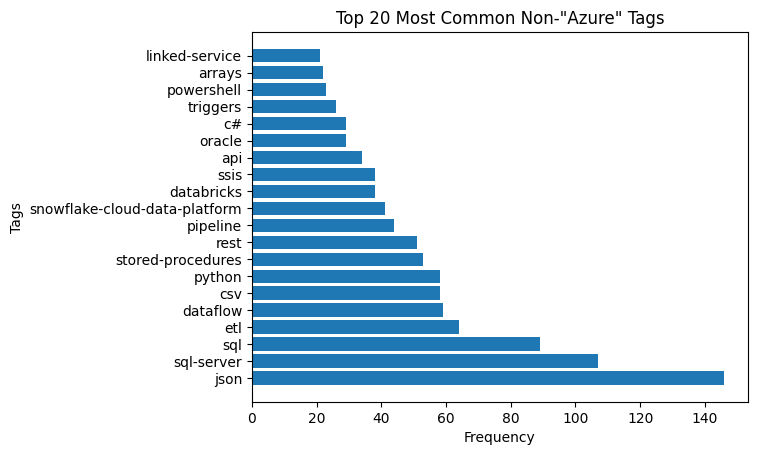

In [8]:
from collections import Counter

# Filter out empty tags as well as tags containing "azure". 

# Find and extract tags
df2['SplitTags'] = df2['QuestionTags'].str.findall('<(.*?)>')

# Explode the DataFrame to have one row per tag
exploded_df = df2.explode('SplitTags')

# Filter out tags containing "azure" and the empty tag
filtered_df = exploded_df[~exploded_df['SplitTags'].str.contains('azure', na=False) & (exploded_df['SplitTags'] != '')]

# Count the non-"azure" tags
non_azure_tags = filtered_df['SplitTags'].values
non_azure_tag_counts = Counter(non_azure_tags)

# Display the top 20 non-"azure" tags
most_common_non_azure_tags = non_azure_tag_counts.most_common(20)

plt.barh([tag for tag, _ in most_common_non_azure_tags], [count for _, count in most_common_non_azure_tags])
plt.xlabel('Frequency')
plt.ylabel('Tags')
plt.title('Top 20 Most Common Non-"Azure" Tags')
plt.show()



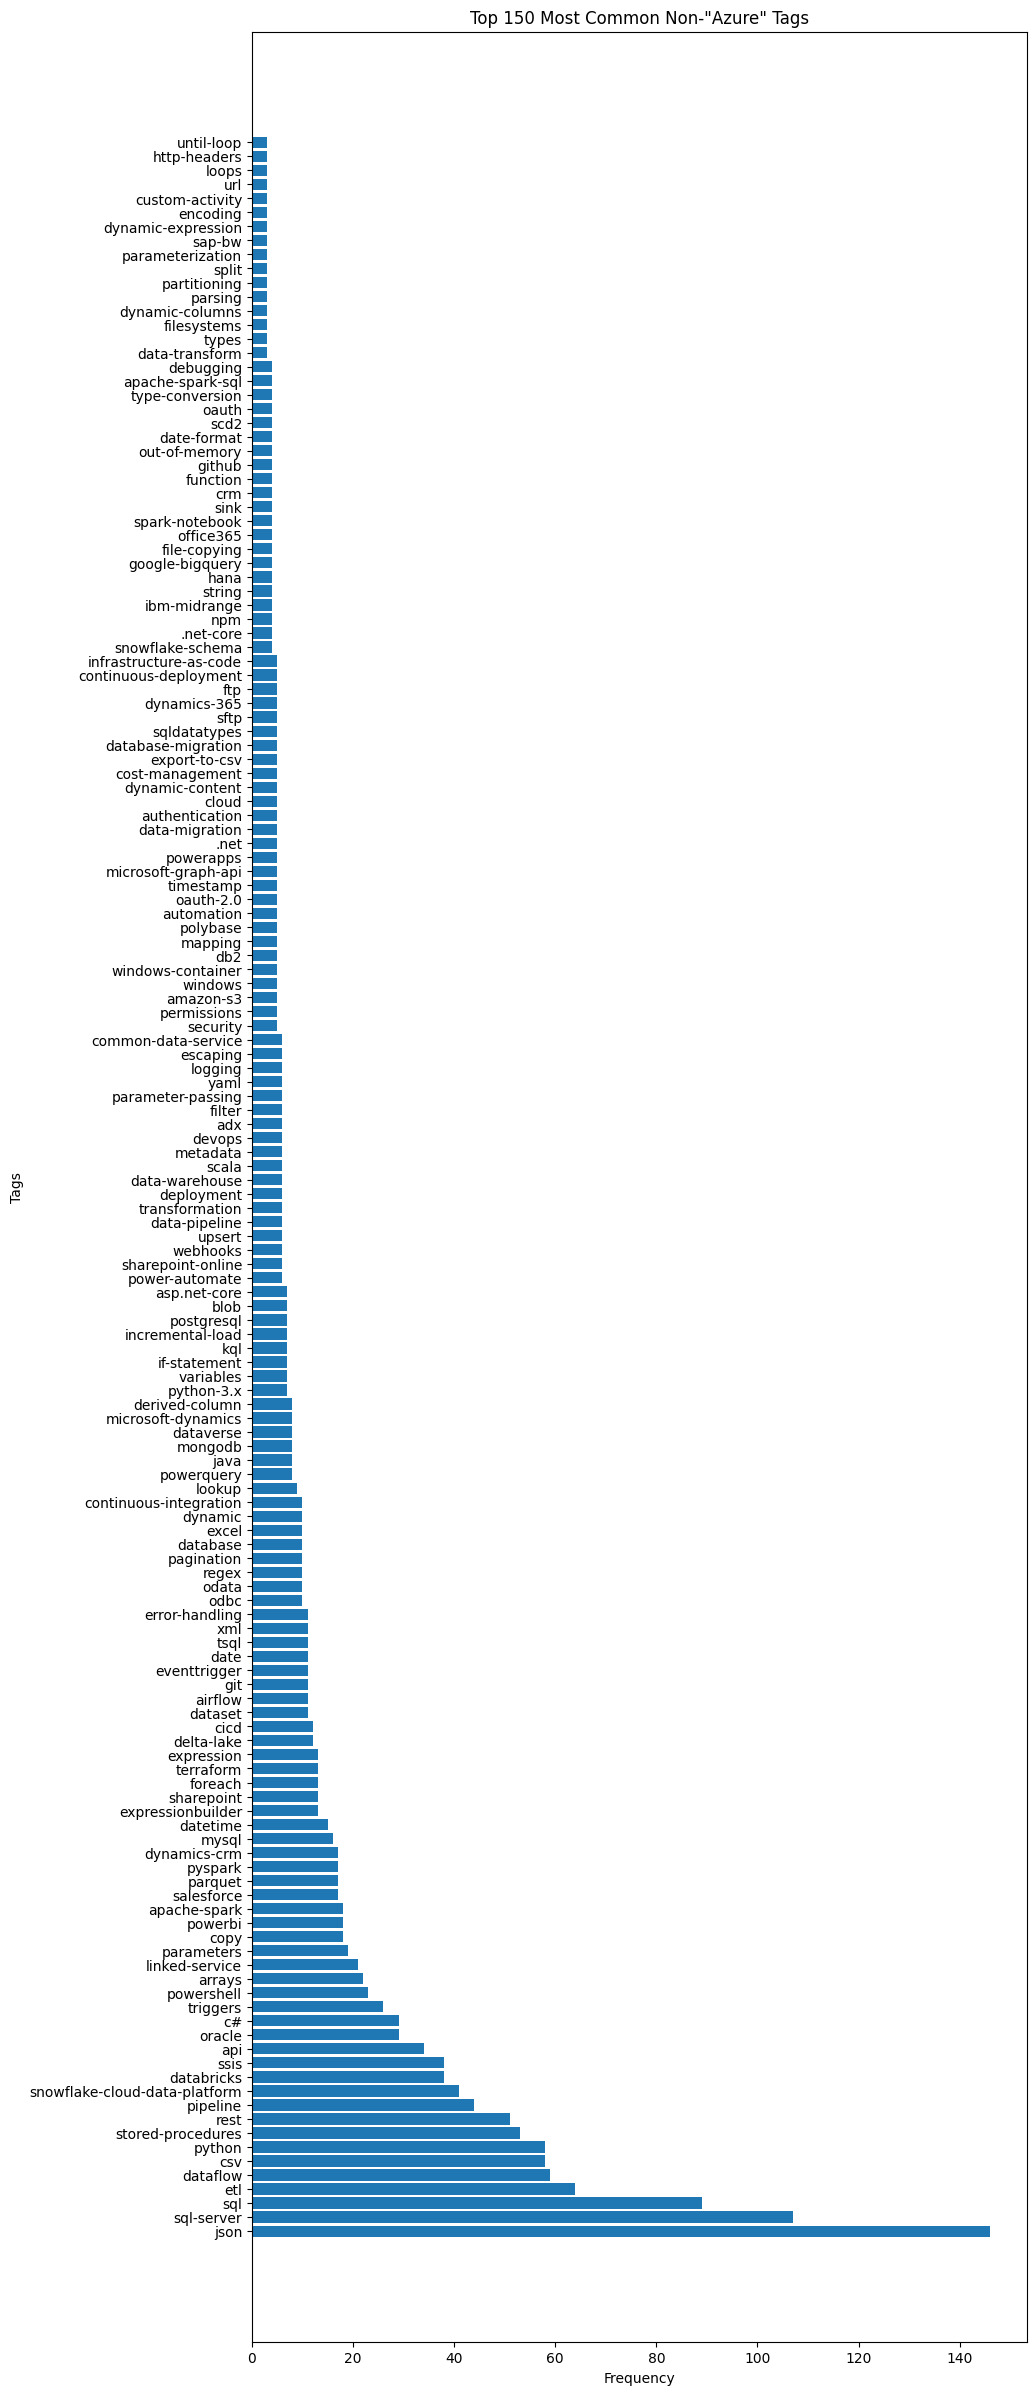

List of the top 150 non-'Azure' tags:
['json', 'sql-server', 'sql', 'etl', 'dataflow', 'csv', 'python', 'stored-procedures', 'rest', 'pipeline', 'snowflake-cloud-data-platform', 'databricks', 'ssis', 'api', 'oracle', 'c#', 'triggers', 'powershell', 'arrays', 'linked-service', 'parameters', 'copy', 'powerbi', 'apache-spark', 'salesforce', 'parquet', 'pyspark', 'dynamics-crm', 'mysql', 'datetime', 'expressionbuilder', 'sharepoint', 'foreach', 'terraform', 'expression', 'delta-lake', 'cicd', 'dataset', 'airflow', 'git', 'eventtrigger', 'date', 'tsql', 'xml', 'error-handling', 'odbc', 'odata', 'regex', 'pagination', 'database', 'excel', 'dynamic', 'continuous-integration', 'lookup', 'powerquery', 'java', 'mongodb', 'dataverse', 'microsoft-dynamics', 'derived-column', 'python-3.x', 'variables', 'if-statement', 'kql', 'incremental-load', 'postgresql', 'blob', 'asp.net-core', 'power-automate', 'sharepoint-online', 'webhooks', 'upsert', 'data-pipeline', 'transformation', 'deployment', 'data-wa

In [9]:
# Show the Top 150 non-Azure keywords

# Find and extract tags
df2['SplitTags'] = df2['QuestionTags'].str.findall('<(.*?)>')

# Explode the DataFrame to have one row per tag
exploded_df = df2.explode('SplitTags')

# Filter out tags containing "azure" and the empty tag
filtered_df = exploded_df[~exploded_df['SplitTags'].str.contains('azure', na=False) & (exploded_df['SplitTags'] != '')]

# Count the non-"azure" tags
non_azure_tags = filtered_df['SplitTags'].values
non_azure_tag_counts = Counter(non_azure_tags)

# Display the top 150 non-"azure" tags
most_common_non_azure_tags = non_azure_tag_counts.most_common(150)

plt.figure(figsize=(10, 30))  # Adjust the plot size for better visibility
plt.barh([tag for tag, _ in most_common_non_azure_tags], [count for _, count in most_common_non_azure_tags])
plt.xlabel('Frequency')
plt.ylabel('Tags')
plt.title('Top 150 Most Common Non-"Azure" Tags')
plt.show()

# Print the list of the top 150 non-"azure" tags
top_150_tags = [tag for tag, _ in most_common_non_azure_tags]
print("List of the top 150 non-'Azure' tags:")
print(top_150_tags)

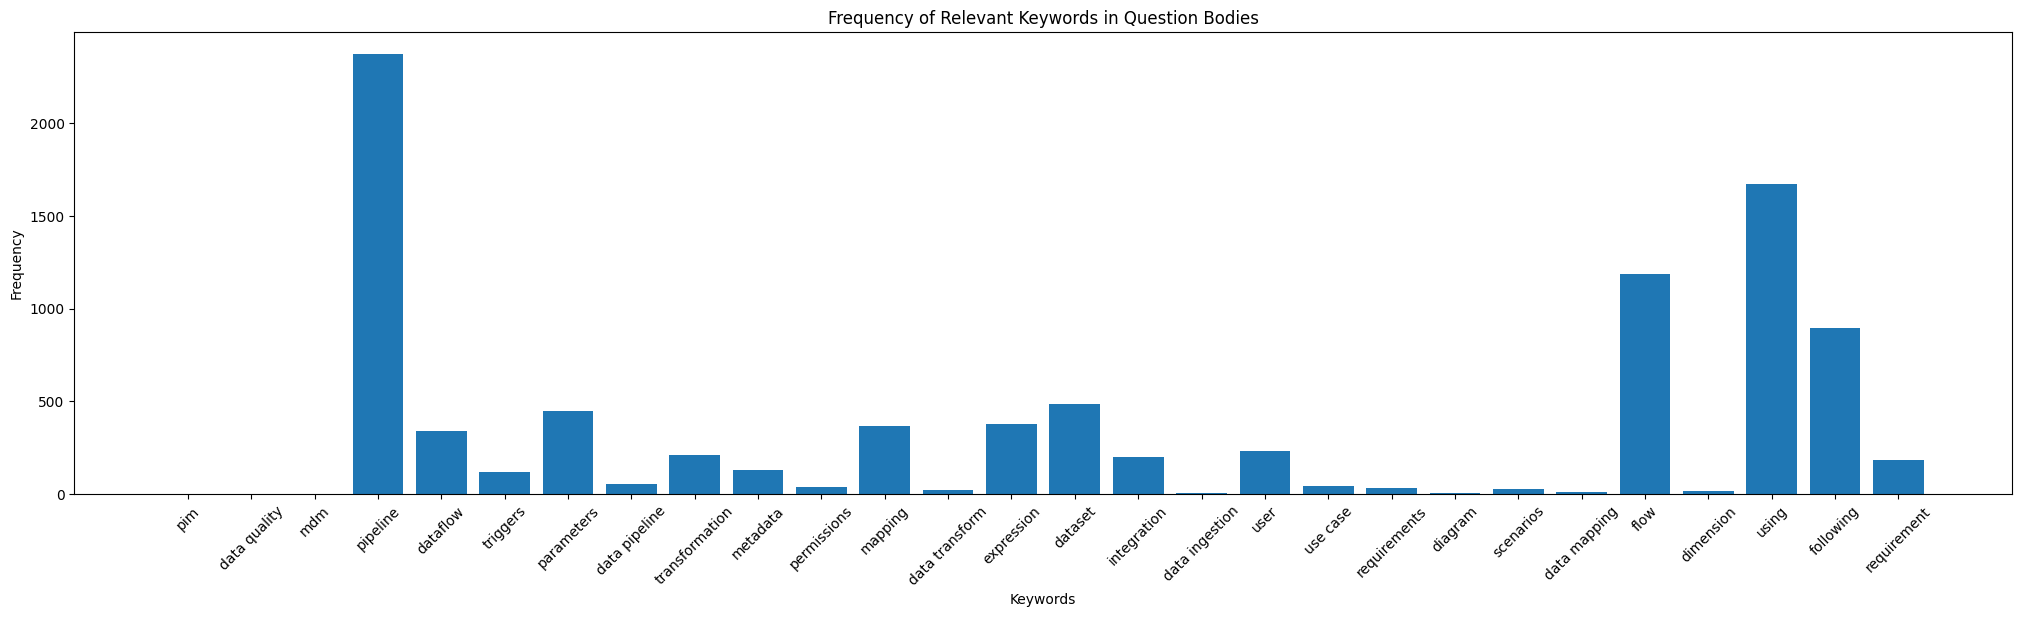

In [10]:
# Frequency of Relevant Keywords in Question Bodies

# Check for relevant keywords relating to requirements engineering, pipeline design, 
# data management or product data management. Keywords were derived from this data set and
# from previous notbooks

keywords_to_plot = ['pim', 'data quality', 'data governance', 'mdm','master data mangement', 'pipeline', 'dataflow', 'triggers', 'parameters', 'eventtrigger', 'data pipeline', 
                    'transformation', 'metadata', 'permissions', 'mapping',
                    'database-migration', 'database migration','snowflake-schema', 'snowflake schema', 'data transform',
                    'data-transform', 'networking', 'expression', 'dataset', 'integration', 'data-ingestion', 'data ingestion', 
                    'user', 'use case', 'system-requirements', 'system requirements', 
                    'use-case-diagram', 'use case diagram', 'requirements', 'modeling', 'diagram', 'scenarios', 
                    'data-synchronization', 'data synchronization', 'data-mapping', 
                    'data mapping', 'dataflow-diagram', 'dataflow diagram', 
                    'master-data-management', 'master data management', 'product-data-management', 'product data management' 
                    'product-data', 'product data', 'data-modelling', 'data modelling', 'dimensional-modelling', 
                    'dimensional modelling', 'star-schema', 'star schema' 'data-quality',
                    'business-intelligence', 'data-transformation', 'data transformation' 'actor', 'system-requirements', 
                    'system requirements', 'flow', 'dimension', 'using', 'following', 'requirement']

# Filter the keywords based on their presence in the 'QuestionTitle' column
keywords_to_plot = [keyword for keyword in keywords_to_plot if any(keyword in title for title in df2['QuestionBody'])]

# Count the occurrences of each keyword in the 'QuestionTitle' column
keyword_counts = {keyword: df2['QuestionBody'].apply(lambda title: keyword in title).sum() for keyword in keywords_to_plot}

# Set the figure size (width, height)
plt.figure(figsize=(25, 6))

# Create a bar plot
plt.bar(keyword_counts.keys(), keyword_counts.values())
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.title('Frequency of Relevant Keywords in Question Bodies')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

**Results**

The data set seems to center around data management in Azure Data Factory in general. Requirements engineering for data piplines is represented by keywords such as "user", "use case", "using", "actor". Data management is presented by keywords such as "flow", "dataflow", "data flow", "dimension", "data integration", "data mapping", "mapping", "etl". Data governance and data quality is represented by the verb "following". There is no significant mentioning of terms such as pim or mdm.

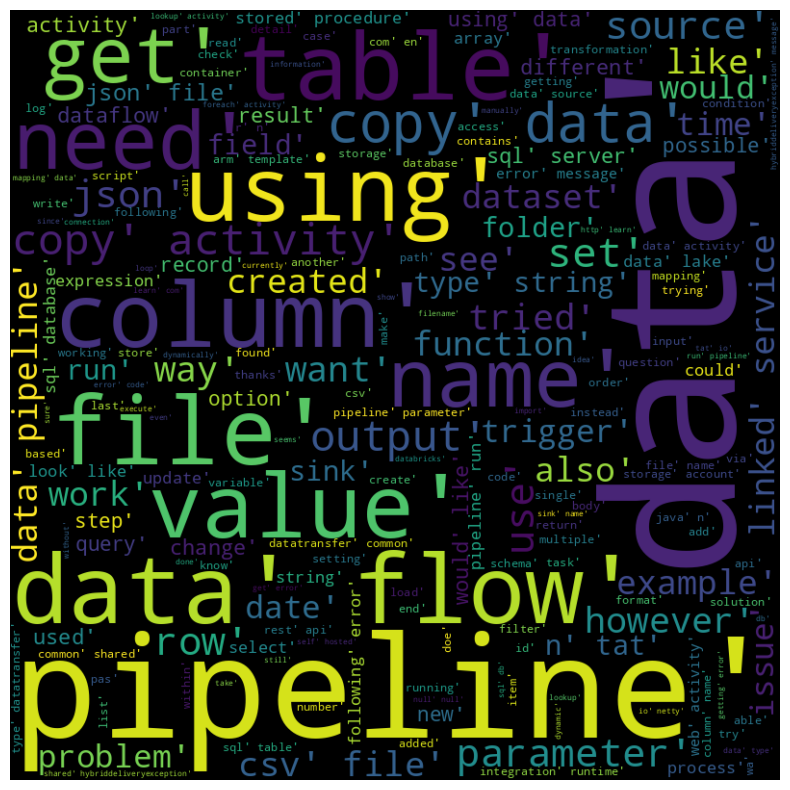

In [11]:
import spacy
import re
from wordcloud import WordCloud, STOPWORDS

# Define stop_words and stop_phrases separately
stop_words = {'adf', 'azure', 'ha', 'microsoft', 'blob', 'factory', 'one', 'two', 
              'first', 'second', 'max', 'mm', 'abc', 
              'three', 'third', 'mm dd', 'apache', 'today', 
              'org apache', 'month', 'qnaid qna', 
              'prem', 'year', 'donesafe', 'day', 'month', 'hour',
              'year', 'yyyy', 'minute', 'daily', 'bi', 'week', 'u'
             }
stop_phrases = {'azure data', 'data factory', 'u u', 'azure data factory', 'azure pipeline', 'azure synapse', 
                  'azure sql database', 'azure data lake', 'azure blob storage', 'azure databricks', 'azure devops'}

# Convert stop words and phrases to lowercase
stop_words = {word.lower() for word in stop_words}
stop_phrases = {phrase.lower() for phrase in stop_phrases}

# Combine stop_words and stop_phrases into one set
all_stop_words = stop_words.union(stop_phrases)

# Load the English language model
nlp = spacy.load('en_core_web_lg')

# Combine all the preprocessed texts into a single string
preprocessed_texts = ' '.join(df2['LemmatizedQuestionBody'].astype(str))

# Remove stop words and stop phrases from the preprocessed_texts
for stopword in all_stop_words:
    preprocessed_texts = re.sub(r'\b' + re.escape(stopword) + r'\b', '', preprocessed_texts, flags=re.IGNORECASE)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=800)

# Generate the word cloud with a larger size (e.g., 800x800) and the preprocessed_texts without stopwords
cloud = wordcloud.generate(preprocessed_texts.lower())

# Display the word cloud
plt.figure(figsize=(10, 10))  # Increase the figure size for better visibility
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()



In [59]:
# Save the plot
#plt.savefig('wordcloud.png')

<Figure size 640x480 with 0 Axes>

**Extractions with spaCy**


In [12]:
from collections import defaultdict

# Define stop words and stop phrases
stop_words = {'microsoft', 'factory', 'one', 'u u', 'two', 
              'first', 'second', 'azure', 'max', 'mm', 'abc', 
              'three', 'third', 'mm dd', 'apache', 'today', 
              'org apache', 'month', 'qnaid qna', 'azure data', 
              'prem', 'year', 'donesafe', 'day', 'month', 'hour',
              'year', 'yyyy', 'minute', 'daily', 'bi', 'week', 'u', 
              'europe', 'ec', 'tenant_id', 'thousand', 'yesterday',
              'adl', 'jan', 'monthly', 'to_date', 'subscription_id', 'created'
             }
stop_phrases = {'azure data', 'data factory', 'u u'}

# Convert stop words and phrases to lowercase
stop_words = {word.lower() for word in stop_words}
stop_phrases = {phrase.lower() for phrase in stop_phrases}

# Combine stop_words and stop_phrases into one set
all_stop_words = stop_words.union(stop_phrases)

# Analyze the text and extract entities, nouns, and verbs
entities_counter = defaultdict(int)
nouns_counter = defaultdict(int)
verbs_counter = defaultdict(int)

for _, row in df2.iterrows():
    question_body = row['LemmatizedQuestionBody']
    
    # Remove stop words and stop phrases from the question_body
    for stopword in all_stop_words:
        question_body = re.sub(r'\b' + re.escape(stopword) + r'\b', '', question_body, flags=re.IGNORECASE)
    
    doc = nlp(question_body)
        
    for ent in doc.ents:
        if ent.text.lower() not in stop_words:
            entities_counter[ent.text.lower()] += 1
        
    for token in doc:
        if token.pos_ == 'NOUN' and token.is_alpha and token.text.lower() not in stop_words:
            nouns_counter[token.text.lower()] += 1
        elif token.pos_ == 'VERB' and token.is_alpha and token.text.lower() not in stop_words:
            verbs_counter[token.text.lower()] += 1

# Display the top 10 most common entities, nouns, and verbs
def display_top_n(counter, n, title):
    print(title)
    for item, count in sorted(counter.items(), key=lambda x: x[1], reverse=True)[:n]:
        print(f"{item}: {count}")
    print()

display_top_n(entities_counter, 10, "Top 10 Entities")
display_top_n(nouns_counter, 10, "Top 10 Nouns")
display_top_n(verbs_counter, 10, "Top 10 Verbs")

Top 10 Entities
dominguez: 28
tom: 21
'quarter': 18
uk: 17
aml': 16
weekly: 15
bob: 15
friday: 13
michael: 12
workday: 12

Top 10 Nouns
data: 8608
pipeline: 5619
file: 4768
activity: 3678
type: 2956
error: 2849
name: 2819
source: 2736
column: 2703
table: 2697

Top 10 Verbs
using: 2542
get: 1979
run: 1543
want: 1439
need: 1403
following: 1128
set: 1119
trying: 1089
tried: 1019
create: 983



**Latent Dirichlet Allocation**

In [13]:
import numpy as np
import random
import gensim
from gensim import corpora
from gensim.models import LdaModel
import ast

# Prepare the input data by using the lemmatized tokens from the 'LemmatizedQuestionBody' column:
documents = df2['LemmatizedQuestionBody'].apply(ast.literal_eval).tolist()

# Set the random seed for numpy and python to ensure the same results each time the allocation re-runs
np.random.seed(42)
random.seed(42)

# Create a dictionary and a bag of words corpus from the documents:
dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(document) for document in documents]

# Set the seed for the random number generator used by the LDA model to a fixed value. 
# Ensures that the same sequence of random numbers is generated every time the model is trained 
# with the same input data and configuration.
random_state_seed = 42 
gensim.models.ldamodel.LdaModel.seed = random_state_seed

# Train the LDA model. You can choose the number of topics by setting the num_topics parameter:
num_topics = 3  # Change this value to the desired number of topics
lda_model1 = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15) # Set the number of passes

# Display the top words for each topic
words_per_topic = 10  # Specify the number of top words per topic
for topic in range(num_topics):
    print(f"Topic {topic + 1}:")
    top_words = lda_model1.show_topic(topic, topn=words_per_topic)
    for word, weight in top_words:
        print(f"  {word}: {weight:.4f}")
    print()

Topic 1:
  data: 0.0243
  table: 0.0154
  column: 0.0150
  value: 0.0124
  type: 0.0113
  source: 0.0112
  pipeline: 0.0103
  error: 0.0095
  using: 0.0083
  name: 0.0082

Topic 2:
  data: 0.0397
  pipeline: 0.0310
  file: 0.0286
  azure: 0.0264
  activity: 0.0243
  copy: 0.0113
  name: 0.0112
  factory: 0.0101
  adf: 0.0097
  error: 0.0096

Topic 3:
  factory: 0.0142
  microsoft: 0.0141
  azure: 0.0124
  n: 0.0119
  pipeline: 0.0111
  name: 0.0096
  com: 0.0090
  new: 0.0089
  http: 0.0083
  data: 0.0080



In [14]:
# Check for total number of missing values
print(df2.isnull().sum().sum())

0


***Prompt GPT4:*** I queried Stackoverflow for questions and answers concerning Azure Data Factory. I used the stackexchange database.This is the query: (insert query code). I then created a Pandas dataframe within Jupyter Notebook to process and analyze the data. After applying NLP processing I created a sub-set of the data filtering by creation date and relevant keywords. These are the filters I applied: (insert code to create_new_df)

On this filtered data I conducted a Latent Dirichlet Allocation with three topics. Below are the respective results. List three alternative titles for each topic ordered descendingly by how relevance of the title.(insert code of LDA and results) 

***Response GPT4:*** Here are the titles and discussions for each topic:


Topic 1:

    "Managing Data Tables and Columns in Azure Data Factory Pipelines"
    "Understanding and Resolving Error Types in Azure Data Factory"
    "Data Source Processing and Value Types in Azure Data Factory"

Topic 2:

    "Managing Data Pipelines and File Activities in Azure Data Factory"
    "Understanding Azure Data Factory: From Data Copying to Error Handling"
    "Azure Data Factory - Naming Conventions and File Handling"

Topic 3:

    "Exploring Microsoft Azure Data Factory: From Pipeline Creation to Data Handling"
    "New Developments in Microsoft Azure Data Factory"
    "Understanding HTTP Requests in Microsoft Azure Data Factory"
    
***Prompt GPT4:*** Summarize the results of the LDA and discuss each topic individually.

***Response GPT4:*** 

Latent Dirichlet Allocation (LDA) is a machine learning technique that is typically used to identify underlying topics in a collection of documents. The LDA that you've performed on your Azure Data Factory questions and answers from StackOverflow has yielded three distinct topics. Here are the summaries and discussions for each topic:

Topic 1: Data Management in Pipelines

This topic seems to primarily focus on the management of data within Azure Data Factory, with a particular emphasis on tables and columns. There also appears to be a significant focus on various data types and data sources. The prominence of the term "error" suggests a discussion around troubleshooting or problem-solving within this context, possibly focusing on issues that arise during data pipeline creation or management.

Topic 2: Azure Data Factory Operations

The second topic seems to center around operations in Azure Data Factory. The frequency of the terms "pipeline", "file", "activity", and "copy" suggests a focus on the practical aspects of moving and managing data within Azure Data Factory. The presence of "error" implies the topic may also involve dealing with problems or complications that arise during these operations.

Topic 3: Microsoft Azure Data Factory Overview

The third topic appears to be a more general discussion about Microsoft Azure Data Factory. The presence of terms like "microsoft", "azure", "factory", and "new" suggests a focus on broader concepts or updates about Azure Data Factory. The term "http" might indicate a discussion about web-based aspects of Azure Data Factory or perhaps how it integrates with other web services.

In summary, the LDA has identified three distinct themes in your dataset: data management within pipelines, practical operations within Azure Data Factory, and a general overview or discussion about Azure Data Factory. This gives you a good idea of the types of discussions that are happening around Azure Data Factory on StackOverflow.  
    
    

In [15]:
# Assign topic names as proposed by GPT4

# Define a function that safely evaluates literals
def safe_literal_eval(s):
    try:
        return ast.literal_eval(s)
    except ValueError:
        return []

# Assign each question to its most relevant topic:
def assign_topic(document):
    bow = dictionary.doc2bow(document)
    topic_distribution = lda_model1.get_document_topics(bow)
    most_relevant_topic = max(topic_distribution, key=lambda x: x[1])[0]
    return most_relevant_topic

# Define a function that returns the topic name based on the index
def get_topic_name(topic_index):
    topic_names = {
        0: 'Data Management in Pipelines',
        1: 'Azure Data Factory Operations',
        2: 'Microsoft Azure Data Factory Overview',
    }
    return topic_names.get(topic_index, '')

# Apply safe_literal_eval and assign_topic functions to the 'LemmatizedQuestionBody' column
df2['LDATopic'] = df2['LemmatizedQuestionBody'].apply(lambda x: assign_topic(safe_literal_eval(x)))

# Assign topic names to a new column 'LDATopicName'
df2['LDATopicName'] = df2['LDATopic'].apply(get_topic_name)

# Check for total number of missing values
print(df2.isnull().sum().sum())

0


In [16]:
# Assign each question to its most relevant topic:
def assign_topic(document):
    bow = dictionary.doc2bow(document)
    topic_distribution = lda_model1.get_document_topics(bow)
    most_relevant_topic = max(topic_distribution, key=lambda x: x[1])[0]
    return most_relevant_topic

df2['LDATopic'] = df2['LemmatizedQuestionBody'].apply(lambda x: assign_topic(ast.literal_eval(x)))

In [17]:
#df2.loc[df2['LDATopic'].isin([0, 1, 2]) == False, 'LDATopic'] = 11

In [18]:
# Define the mapping from 'LDATopic' to 'LDATopicName'
topic_name_mapping = {
    #11: "No Topic Assigned",
    0: "Data Management in Pipelines",
    1: "Azure Data Factory Operations",
    2: "Microsoft Azure Data Factory Overview",
}

# Apply the mapping to the 'LDATopic' column to create the 'LDATopicName' column
df2['LDATopicName'] = df2['LDATopic'].map(topic_name_mapping)

In [19]:
len(df2)

4035

In [20]:
topic_distribution = df2['LDATopic'].value_counts()
print(topic_distribution)

LDATopic
0    2097
1    1280
2     658
Name: count, dtype: int64


In [21]:
topic_distribution = df2['LDATopicName'].value_counts()
print(topic_distribution)

LDATopicName
Data Management in Pipelines             2097
Azure Data Factory Operations            1280
Microsoft Azure Data Factory Overview     658
Name: count, dtype: int64


In [22]:
# The VADER sentiment analyzer is designed especially for sentiment analysis on social media texts 
# Use raw, unprocessed text the way it comes out of social media.

import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Define a function to calculate the sentiment scores
def get_sentiment_score(text):
    return sia.polarity_scores(text)

# Apply the function to the 'QuestionBody' column and store the sentiment scores in a new column
df2['VaderSentimentScores'] = df2['QuestionBody'].apply(get_sentiment_score)

# Calculate the average sentiment score for each topic
avg_sentiment_by_topic = df2.groupby('LDATopicName')['VaderSentimentScores'].apply(lambda scores: pd.DataFrame(scores.tolist()).mean())

print(avg_sentiment_by_topic)


LDATopicName                                   
Azure Data Factory Operations          neg         0.031105
                                       neu         0.909595
                                       pos         0.059299
                                       compound    0.212253
Data Management in Pipelines           neg         0.027964
                                       neu         0.908656
                                       pos         0.063393
                                       compound    0.311001
Microsoft Azure Data Factory Overview  neg         0.042655
                                       neu         0.905641
                                       pos         0.051661
                                       compound    0.041539
Name: VaderSentimentScores, dtype: float64


***Prompt GPT4:*** I conducted Vader Sentiment Analysis on the resulting three topics of the LDA. Summarize the Vader results and discuss each topic individually. (insert code and results of Vader Sentiment Analysis)

***Response GPT4:*** Vader Sentiment Analysis is a method used to determine the sentiment of a text, which is particularly effective for social media content. It gives a compound score that calculates the sentiment of the text as a whole, and also provides scores for positive, negative, and neutral sentiments separately.

Here are the summaries and discussions for each topic based on the Vader Sentiment Analysis results:

Topic 1: Data Management in Pipelines

The sentiment analysis for this topic has a negative score of 0.0279, a neutral score of 0.9086, a positive score of 0.0634, and a compound score of 0.3110. The high neutral score indicates that the discussion is mostly factual or objective. The compound score, which considers the balance of positive and negative sentiments, is positive, suggesting an overall positive sentiment in this topic. However, the positive sentiment is not overwhelming, given the relatively low positive score.

Topic 2: Azure Data Factory Operations

The sentiment analysis for this topic has a negative score of 0.0311, a neutral score of 0.9096, a positive score of 0.0593, and a compound score of 0.2123. Similar to Topic 1, this topic also shows a high neutral score, indicating a predominance of objective or factual discussions. The compound score is also positive but less than Topic 1, indicating a more subdued overall positive sentiment.

Topic 3: Microsoft Azure Data Factory Overview

The sentiment analysis for this topic has a negative score of 0.0427, a neutral score of 0.9056, a positive score of 0.0517, and a compound score of 0.0415. This topic has a slightly higher negative sentiment compared to the other topics, but the majority of the content is still rated as neutral. The compound score is quite low, suggesting a relatively balanced mix of positive and negative sentiments, with a slight inclination towards the positive side.

In summary, all three topics are mainly neutral, reflecting objective, fact-based discussions typical of technical forums like StackOverflow. Topics 1 and 2 have a mildly positive sentiment overall, while Topic 3 is more balanced with a slight positive inclination.

In [23]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()

def custom_topic_names(topic_number):
    topic_names = {
        0: 'Data Management in Pipelines',
        1: 'Azure Data Factory Operations',
        2: 'Microsoft Azure Data Factory Overview',
    }
    return topic_names.get(topic_number, '')

lda_viz = gensimvis.prepare(lda_model1, corpus, dictionary)

for i in range(num_topics):
    lda_viz.topic_info.loc[lda_viz.topic_info.Category == f'Topic{i+1}', 'Category'] = custom_topic_names(i)
    lda_viz.topic_coordinates.loc[i, 'topics'] = custom_topic_names(i)

pyLDAvis.display(lda_viz)

In [60]:
# Save the visualization as an HTML file
#pyLDAvis.save_html(lda_viz, 'lda_visualization.html')

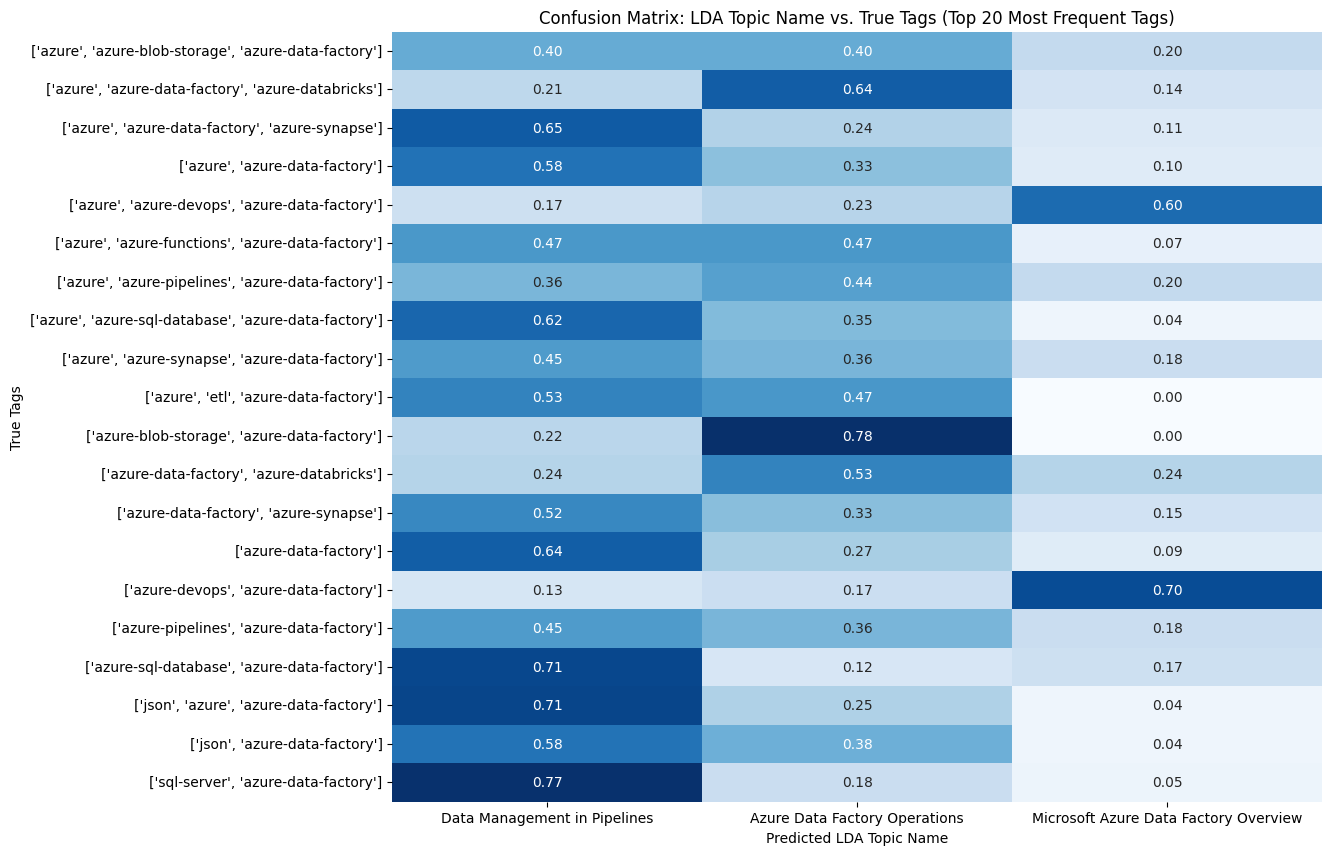

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

df2_top_n_tags = 20

# Get the top N most frequent tags
df2_top_tags = df2['Tags'].value_counts().nlargest(df2_top_n_tags).index.tolist()

# Filter the dataset
df2_filtered_df2 = df2[df2['Tags'].isin(df2_top_tags)]

# Create a confusion matrix
confusion_matrix = pd.crosstab(df2_filtered_df2['Tags'], df2_filtered_df2['LDATopic'])

# Normalize the confusion matrix by row to show proportions
df2_normalized_confusion_matrix = confusion_matrix.div(confusion_matrix.sum(axis=1), axis=0)

# Replace the column labels with the corresponding topic names
df2_normalized_confusion_matrix.columns = [topic_name_mapping[col] for col in df2_normalized_confusion_matrix.columns]

# Order the columns by the topic number
ordered_columns = [topic_name_mapping[i] for i in sorted(topic_name_mapping.keys())]

df2_normalized_confusion_matrix = df2_normalized_confusion_matrix[ordered_columns]

plt.figure(figsize=(12, 10))
sns.heatmap(df2_normalized_confusion_matrix, annot=True, fmt='.2f', cmap='Blues', cbar=False)

plt.xlabel('Predicted LDA Topic Name')
plt.ylabel('True Tags')
plt.title('Confusion Matrix: LDA Topic Name vs. True Tags (Top {} Most Frequent Tags)'.format(df2_top_n_tags))
plt.show()

Using only two topics will lead to many unassigned row. Using five topics will strengthen topic 1. There seems to be one very strong topic within the data. In order to create more than one topic and to assign a topic to each row, three topics were found to be the ideal number of topics. 

In [61]:
# Save the figure
#plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

In [25]:
# Extract top entities, verbs and nouns from each topic

from collections import defaultdict
import spacy


# Define stop words and stop phrases
stop_words = {'microsoft', 'factory', 'one', 'u u', 'two', 
              'first', 'second', 'azure', 'max', 'mm', 'abc', 
              'three', 'third', 'mm dd', 'apache', 'today', 
              'org apache', 'month', 'qnaid qna', 'azure data', 
              'prem', 'year', 'donesafe', 'day', 'month', 'hour',
              'year', 'yyyy', 'minute', 'daily', 'bi', 'week', 'u', 
              'europe', 'ec', 'tenant_id', 'thousand', 'yesterday',
              'adl', 'jan', 'monthly', 'to_date', 'subscription_id', 'created'
             }
stop_phrases = {'azure data', 'data factory', 'u u'}

# Convert stop words and phrases to lowercase
stop_words = {word.lower() for word in stop_words}
stop_phrases = {phrase.lower() for phrase in stop_phrases}

# Combine stop_words and stop_phrases into one set
all_stop_words = stop_words.union(stop_phrases)

# Analyze the text and extract entities, nouns, and verbs for each topic
topic_entities_counter = defaultdict(lambda: defaultdict(int))
topic_nouns_counter = defaultdict(lambda: defaultdict(int))
topic_verbs_counter = defaultdict(lambda: defaultdict(int))

for _, row in df2.iterrows():
    question_body = row['LemmatizedQuestionBody']
    topic = row['LDATopic']
    
    if topic != 11:
        # Remove stop words and stop phrases from the question_body
        for stopword in all_stop_words:
            question_body = re.sub(r'\b' + re.escape(stopword) + r'\b', '', question_body, flags=re.IGNORECASE)
        
        doc = nlp(question_body)
            
        for ent in doc.ents:
            if ent.text.lower() not in stop_words:
                topic_entities_counter[topic][ent.text.lower()] += 1
            
        for token in doc:
            if token.pos_ == 'NOUN' and token.is_alpha and token.text.lower() not in stop_words:
                topic_nouns_counter[topic][token.text.lower()] += 1
            elif token.pos_ == 'VERB' and token.is_alpha and token.text.lower() not in stop_words:
                topic_verbs_counter[topic][token.text.lower()] += 1

# Display the top 20 most common entities, nouns, and verbs for each topic
def display_top_n_for_each_topic(topic_counter, n, title):
    for topic in topic_counter:
        print(f"Topic {topic + 1} {title}:")
        counter = topic_counter[topic]
        for item, count in sorted(counter.items(), key=lambda x: x[1], reverse=True)[:n]:
            print(f"{item}: {count}")
        print()

display_top_n_for_each_topic(topic_entities_counter, 20, "Entities")
display_top_n_for_each_topic(topic_nouns_counter, 20, "Nouns")
display_top_n_for_each_topic(topic_verbs_counter, 20, "Verbs")

Topic 2 Entities:
'quarter': 9
sunday: 6
monday: 6
bab: 5
mycontainer: 5
weekly: 4
ibm: 4
'july': 4
'weekend': 3
eveyday: 2
tuesday: 2
sec: 2
dataload_dir: 2
user_key: 2
aws_profile: 2
deloitte: 2
weekday: 2
tomorrow: 1
tom: 1
michael: 1

Topic 1 Entities:
dominguez: 28
tom: 20
bob: 15
workday: 12
michael: 11
friday: 11
nl: 10
weekly: 10
kristopher: 10
tables_to_create: 9
jack: 8
usa: 8
myschema: 8
december: 8
xero: 8
australia: 7
india: 7
france: 7
'weekend': 7
d_type: 7

Topic 3 Entities:
aml': 15
uk: 10
ephemeral_nfs: 8
tf: 8
eu: 8
japanese: 7
mfa: 6
tr_properties: 6
'quarter': 6
ddc: 6
dbc: 5
dc: 5
irs: 5
org_daily_data_load: 5
ls_asdb: 5
mycontainer: 4
ge: 4
dfid: 4
dallas: 4
cathay: 4

Topic 2 Nouns:
data: 2653
file: 2289
pipeline: 2141
activity: 1402
copy: 952
adf: 751
blob: 651
error: 647
storage: 588
source: 587
table: 561
name: 500
trigger: 447
use: 443
way: 383
container: 345
message: 341
type: 300
service: 277
server: 273

Topic 1 Nouns:
data: 4712
column: 2442
pipeline: 24

***Prompt GPT4:*** I also extracted the most important entities, verbs, and nouns for each topic using spaCy. Considering the results of the LDA, the Vader Sentiment Analysis and the spaCy extractions as well as the Certified Professional for Requirements Engineering (CPRE) certification: Which functional and non-functional requirements are expressed by the users on Stackoverflow concerning Azure Data Factory? List the requirements for each of the LDA Topics.

***Response GPT4:***

Based on the combination of the LDA results, Vader Sentiment Analysis, and the spaCy extractions, the users' functional and non-functional requirements concerning Azure Data Factory can be derived.

Topic 1: Data Management in Pipelines

Functional requirements:

    Provide a way to handle 'cust_id', 'taxonomie_id', 'stg', 'msgid', 'dw_gl', and 'equipment_id' entities efficiently in data pipelines.
    Improve handling of data, columns, pipelines, values, tables, activities, and files (top nouns).
    Users want to get, add, and store data using pipelines (top verbs).

Non-functional requirements:

    Data processing should be efficient even with large quantities of data ('data': 4712 mentions in nouns).
    The process of using pipelines should be made easier and more intuitive (reflected in the verbs: using, want, tried, trying).

Topic 2: Azure Data Factory Operations

Functional requirements:

    Users need better management of 'sqldb', 'quarter', 'ibm', 'hourly', 'weekend', and 'july' entities in Azure Data Factory operations.
    Improve functionality related to data, files, pipelines, activities, copies, blobs, errors, storage, and sources (top nouns).
    Users want to get data, and they're trying to use Azure Data Factory for various operations (top verbs).

Non-functional requirements:

    Improve error handling and reporting (error: 647 mentions in nouns).
    Make the process of using Azure Data Factory for operations more efficient and user-friendly (using: 679 mentions in verbs).

Topic 3: Microsoft Azure Data Factory Overview

Functional requirements:

    Users require better handling of 'jdbc', 'ephemeral_nfs', 'create_run', 'kv_rg_name_seqnr', and 'test_job' entities.
    Improve management of data, pipelines, errors, types, parameters, names, strings, files, and messages (top nouns).
    Users are trying to use Azure Data Factory and are encountering failures (top verbs).

Non-functional requirements:

    Users need better error information and improved stability (error: 944 mentions in nouns).
    Improve the ease of use and learning curve for Azure Data Factory (using: 564 mentions in verbs).

These requirements are derived by interpreting the most frequent nouns, verbs, and entities and may not reflect the full complexity of the user needs as expressed in the StackOverflow discussions. To get a deeper understanding, a more detailed qualitative analysis of the discussions would be needed.



***Prompt GPT4:*** For each topic generate keywords which represent functional and non functional requirements. For each keyword summarize which requirement it represents. 

***Response GPT4:***

Topic 1: Data Management in Pipelines

Functional Requirements Keywords:

    cust_id: Requirement for the efficient handling of customer identifiers in the data pipelines.

    taxonomie_id: Requirement for managing taxonomy identifiers effectively within the pipelines.

    stg: Requirement to handle 'staging' areas or concepts effectively in the data pipelines.

    msgid: Requirement for the effective management of message identifiers in the data pipelines.

    data, columns, pipelines, values, tables, activities, files: Requirement for improved handling and management of these key elements within Azure Data Factory.

Non-Functional Requirements Keywords:

    using: Requirement for the platform to be user-friendly and easy to use.

    get, add, store: Requirement for the platform to efficiently perform these basic operations.

    tried, trying: Requirement for better support and documentation to aid users in their attempts to use the platform.

Topic 2: Azure Data Factory Operations

Functional Requirements Keywords:

    sqldb: Requirement for seamless integration and efficient handling of SQL databases.

    quarter, hourly, weekend: Requirement for flexible and efficient time-based operations.

    data, files, pipelines, activities, copies, blobs, errors, storage, sources: Requirement for improved functionality related to these key elements within Azure Data Factory.

Non-Functional Requirements Keywords:

    error: Requirement for robust error handling and clear, informative error messages.

    using, get: Requirement for the platform to be intuitive and for basic operations like 'getting' data to be straightforward.

    trying: Requirement for better support and guidance for users trying to carry out operations.

Topic 3: Microsoft Azure Data Factory Overview

Functional Requirements Keywords:

    jdbc, ephemeral_nfs, create_run: Requirement for better support for these technologies and operations in Azure Data Factory.

    data, pipelines, errors, types, parameters, names, strings, files, messages: Requirement for improved handling and management of these key elements.

Non-Functional Requirements Keywords:

    error: Requirement for better error handling and more informative error messages.

    using, trying, failed: Requirement for the platform to be user-friendly, with better support and guidance for users trying to use Azure Data Factory and encountering difficulties.

In [26]:
# Topic 1 "Data Management in Pipelines" faired best in the confusion matrix. Therefore a deeper analysis of the data should only be applied to topic 1.
# Based on the presence of certain keywords in the question body this script allows for a review of functional and non-functional requirement questions for topic1

functional_keywords_topic1 = ['cust_id', 'taxonomie_id', 'stg', 'msgid']
non_functional_keywords_topic1 = ['using', 'get', 'add', 'store', 'tried','trying']

# Filter questions related to functional requirements for LDATopic equals 1
functional_questions_topic1 = df2[(df2['LDATopic'] == 1) & df2['QuestionBody'].str.contains('|'.join(functional_keywords_topic1))]

print("Functional Requirement Questions (LDATopic equals 1):")

for i, row in functional_questions_topic1.iterrows():
    question = row['QuestionBody']
    keyword = next((kw for kw in functional_keywords_topic1 if kw in question), None)
    if keyword:
        print(f"{i + 1}. [{keyword.upper()}] {question}")

print()

# Filter questions related to non-functional requirements for LDATopic equals 1
non_functional_questions_topic1=df2[(df2['LDATopic'] == 1) & df2['QuestionBody'].str.contains('|'.join(non_functional_keywords_topic1))]

print("Non-Functional Requirement Questions Topic 1):")

for i, row in non_functional_questions_topic1.iterrows():
    question = row['QuestionBody']
    keyword = next((kw for kw in non_functional_keywords_topic1 if kw in question), None)
    if keyword:
        print(f"{i + 1}. [{keyword.upper()}] {question}")

Functional Requirement Questions (LDATopic equals 1):
1453. [STG] <p>I need help here, so my task is to perform upsert in the ADF pipeline for PostgreSQL. The way that I tried to do is with simple copy activity but is not allowing me to do write behavior for the postgre db. So the way that I'm tring now is with stored procedure activity, but the activity is not allowing me to create a linked service to the postgre db. If not with stored procedure then how is possible to do upsert? Anyone who can help?
Thanks in advance!</p>

2083. [STG] <p>I have set up a ADF pipeline that gets a set of .Zip files from Azure Storage, and iterates through each Zip file's folders and files to land them in an output container with preserved hierarchy.</p>
<p><strong>Get Metadata:</strong>
<a href="https://i.stack.imgur.com/Pd6xR.png" rel="nofollow noreferrer"><img src="https://i.stack.imgur.com/Pd6xR.png" alt="enter image description here" /></a></p>
<p><strong>For Each:</strong>
<a href="https://i.stack.

***Prompt GPT4:*** For each topic generate keywords which represent functional and non functional requirements. For each keyword summarize which requirement it represents. 

***Response GPT4:***

Topic 1: Data Management in Pipelines

Functional Requirements:

    Data Identifier Management: Efficient handling of customer identifiers (cust_id) and taxonomy identifiers (taxonomie_id) in the data pipelines.

    Data Staging: Management of 'staging' areas or concepts effectively in the data pipelines.

    Message Identifier Management: Effective management of message identifiers (msgid) in the data pipelines.

    Data Pipeline Operations: Improved handling and management of key elements (data, columns, pipelines, values, tables, activities, files) within Azure Data Factory.

Non-Functional Requirements:

    Usability: The platform should be user-friendly and easy to use (using).

    Operational Efficiency: Efficient performance of basic operations like getting and adding data (get, add, store).

    Support and Documentation: Better support and documentation to aid users in their attempts to use the platform (tried, trying).

Topic 2: Azure Data Factory Operations

Functional Requirements:

    SQL Database Integration: Seamless integration and efficient handling of SQL databases (sqldb).

    Time-Based Operations: Flexible and efficient time-based operations (quarter, hourly, weekend).

    Data Operations: Improved functionality related to key elements (data, files, pipelines, activities, copies, blobs, errors, storage, sources) within Azure Data Factory.

Non-Functional Requirements:

    Error Handling: Robust error handling and clear, informative error messages (error).

    Usability: The platform should be intuitive and for basic operations like 'getting' data to be straightforward (using, get).

    Support: Better support and guidance for users trying to carry out operations (trying).

Topic 3: Microsoft Azure Data Factory Overview

Functional Requirements:

    Technology Support: Better support for technologies and operations like JDBC, ephemeral NFS, and create_run in Azure Data Factory (jdbc, ephemeral_nfs, create_run).

    Data Management: Improved handling and management of key elements (data, pipelines, errors, types, parameters, names, strings, files, messages).

Non-Functional Requirements:

    Error Management: Better error handling and more informative error messages (error).

    Usability and Support: The platform should be user-friendly, with better support and guidance for users trying to use Azure Data Factory and encountering difficulties (using, trying, failed).

***Prompt GPT4:*** How can the suggested requirements and their respective categories be validated?

***Response GPT4:***

There are several methods to validate the suggested requirements and their respective categories. Here are some of the ways you might consider:

    Stakeholder Interviews: You can validate the requirements by interviewing the stakeholders, including users, developers, project managers, and administrators. During the interviews, you could ask them about the identified requirements and their categories to confirm if these are in line with their needs and expectations.

    Surveys and Questionnaires: These can be used to gather feedback on the requirements from a large number of users. This could include questions about the importance and relevance of each requirement.

    Prototyping: Creating a prototype of the system or feature can be a useful way to validate requirements. Users can interact with the prototype and give feedback on whether it meets the requirements.

    User Stories and Use Cases: Develop user stories and use cases based on the requirements. These narratives describe how a user interacts with the system and helps to validate if the requirements are well understood and meet user needs.

    Requirements Review Meetings: Organize meetings with stakeholders where the proposed requirements and their categories are reviewed. Feedback and suggestions are collected during these sessions.

    Prioritization: Rank the requirements in order of importance to the users and the business. This can help to validate if the right requirements have been identified.

Remember, the goal is to ensure that the requirements are necessary, feasible, and valuable. They should be in alignment with the strategic direction of the product or service, and they should be something that the development team has the capability to deliver.

In [27]:
#df2.to_csv('adf_filtered_df_with_lda_topics.csv', index=True)

**Create dataset for machine learning**

- Keep only topic 0 for supervised machine learning
- add rows from raw data set including all ADF related questions

In [28]:
# Reset the index in both dataframes
df = df.reset_index()
df2 = df2.reset_index()

# Convert the 'LDATopic' column to integers
df2['LDATopic'] = pd.to_numeric(df2['LDATopic'], errors='coerce')

# Fill missing values in the 'LDATopic' column with 11
df2['LDATopic'] = df2['LDATopic'].fillna(11)

# Perform a left merge on the common column ('index' in this case)
merged_df2 = df.merge(df2[['index', 'LDATopic']], on='index', how='left')

# Drop the 'index' column
merged_df2 = merged_df2.drop(columns=['index'])

# Fill missing values in the 'LDATopic' column with 11
merged_df2['LDATopic'] = merged_df2['LDATopic'].fillna(11)

In [29]:
len(merged_df2)

8547

In [30]:
# Set all values within column 'LDATopic' which unequal 0 or 11 to be 11
merged_df2['LDATopic'] = merged_df2['LDATopic'].apply(lambda x: x if x == 0 or x == 11 else 11)

In [31]:
merged_df2['LDATopic'] = merged_df2['LDATopic'].astype(int)
topic_distribution = merged_df2['LDATopic'].value_counts()
print(topic_distribution)

LDATopic
11    6450
0     2097
Name: count, dtype: int64


In [32]:
# Define the mapping from 'LDATopic' to 'LDATopicName'
topic_name_mapping = {
    11: "No Topic Assigned",
    0: "Topic1",
}

# Apply the mapping to the 'LDATopic' column to create the 'LDATopicName' column
merged_df2['LDATopicName'] = merged_df2['LDATopic'].map(topic_name_mapping)

In [ ]:
#merged_df2.to_csv('merged_adf_df_with_lda_topic1.csv', index=True)

**Turning topic scores into features**

In [34]:
# Initialize a list to hold the topic scores for topic 0
topic_scores = []

# For each document, get the topic distribution
for bow in corpus:
    doc_topics = lda_model1.get_document_topics(bow)

    # For each document, iterate over the topics and keep the score for topic 0
    for topic, score in doc_topics:
        if topic == 0:  # If this is topic 0, keep the score
            topic_scores.append(score)
            break
    else:
        # If topic 0 was not in the document's topics, append a 0
        topic_scores.append(0)

# Now `topic_scores` is a list containing the score for topic 0 for each document.
# You can use this as a feature in your supervised model.

In [35]:
# Append the topic_scores list as a new column in df2
df2['Topic0Score'] = topic_scores

In [36]:
merged_df2.columns

Index(['Unnamed: 0', 'QuestionId', 'QuestionTitle', 'QuestionBody',
       'QuestionTags', 'Date', 'ViewCount', 'Score', 'NumberOfAnswers',
       'AnswerId', 'AnswerBody', 'SplitTags', 'YearMonth',
       'CleanedQuestionBody', 'CleanedAnswerBody', 'Tags', 'TagsInTitle',
       'TokenizedQuestionBody', 'TokenizedAnswerBody',
       'LemmatizedQuestionBody', 'LemmatizedAnswerBody', 'CreationDate',
       'LDATopic', 'LDATopicName'],
      dtype='object')

In [39]:
# Make a copy of df2 to avoid changing the original dataframe
df2_copy = df2.copy()

# Set Topic0Score to NaN for rows that do not belong to topic 0
df2_copy.loc[df2_copy['LDATopic'] != 0, 'Topic0Score'] = np.nan

# Append merged_df2 to df2_copy
merged_df = pd.concat([df2_copy, merged_df2], ignore_index=False)
# Fill NaN values with 0
merged_df['Topic0Score'] = merged_df['Topic0Score'].fillna(0)

In [ ]:
merged_df.head()

In [41]:
# Set all values within column 'LDATopic' which unequal 0 or 11 to be 11
merged_df['LDATopic'] = merged_df['LDATopic'].apply(lambda x: x if x == 0 or x == 11 else 11)

In [42]:
merged_df['LDATopic'] = merged_df['LDATopic'].astype(int)
topic_distribution = merged_df['LDATopic'].value_counts()
print(topic_distribution)

LDATopic
11    8388
0     4194
Name: count, dtype: int64


In [44]:
# Set all values within column 'LDATopic' which unequal 0 or 11 to be 11
merged_df['LDATopic'] = merged_df['LDATopic'].apply(lambda x: x if x == 0 or x == 11 else 11)

In [46]:
# keep only topic one for supervised machine learning

topic_distribution = merged_df['LDATopic'].value_counts()
print(topic_distribution)

LDATopic
11    8388
0     4194
Name: count, dtype: int64


In [47]:
# Define the mapping from 'LDATopic' to 'LDATopicName'
topic_name_mapping = {
    11: "No Topic Assigned",
    0: "Topic1",
}

# Apply the mapping to the 'LDATopic' column to create the 'LDATopicName' column
merged_df['LDATopicName'] = merged_df['LDATopic'].map(topic_name_mapping)

In [48]:
# keep only topic one for supervised machine learning

topic_distribution = merged_df['LDATopic'].value_counts()
print(topic_distribution)

LDATopic
11    8388
0     4194
Name: count, dtype: int64


In [49]:
# keep only topic one for supervised machine learning

topic_distribution = merged_df['LDATopicName'].value_counts()
print(topic_distribution)

LDATopicName
No Topic Assigned    8388
Topic1               4194
Name: count, dtype: int64


In [52]:
len(merged_df)

12582

In [53]:
merged_df.drop_duplicates(subset=['AnswerId'], inplace=True)

In [54]:
len(merged_df)

8547

In [55]:
merged_df.loc[merged_df['LDATopic'] != 0, 'Topic0Score'] = 0

In [57]:
#merged_df.to_csv('merged_adf_df_with_lda_topic1_scores.csv', index=True)